# Deep Reinforcement Learning for Supply Chain and Price Optimization

This is the first part of the tutorial focused on price optimization. We define an environment with a complex price-demand function and implement DQN that jointly optimizes the price schedule for several time steps ahead.

### Detailed Description
See D003 in [descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md)

### Data
We use an internal simulator. No external datasets are used.

### Papers
Kemmer2018 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md))

In [39]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import animation, rc
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from qbstyles import mpl_style
mpl_style(dark=False)


# Environment: Assymetric Price Response and Hi-Lo Pricing

Traditional price optimization assumes a simple known parametric price-response function. Optimization under such an assumption is relatively straightforward,
even in case of inventory constraints or other factors. Many basic formulations
can be solved analytically, and many others can be solved numerically. The challenge is typcially in estimating the price-reponse function, not in 
the optimization part.

In some cases, however, optimization also becomes a challenge. This section introduces an example of a price-demand function with temporal dependencies. The optimal price schedule for such a functon has a sawtooth shape.

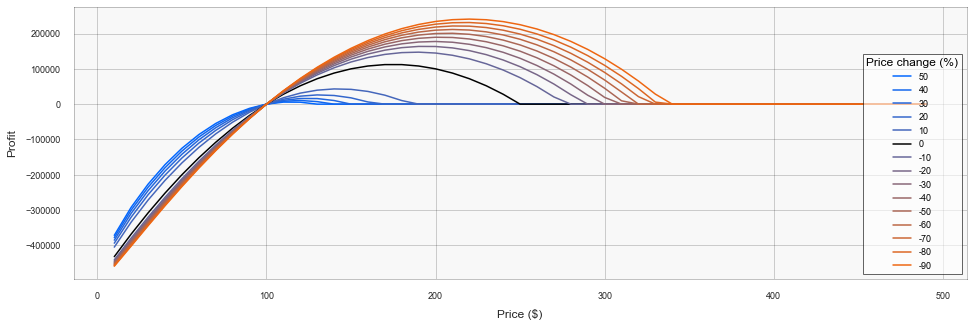

In [43]:
## Environment simulator
def plus(x):
    return 0 if x < 0 else x

def minus(x):
    return 0 if x > 0 else -x

def shock(x):
    return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## Environment parameters
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 100
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)

## Visualize price-demand functions
price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])

plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'black'
    else:
        p_norm = (price_change_grid[i]-0.5)/1.5
        color = (p_norm, 0.4, 1 - p_norm)
    plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((1-price_change_grid)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)
plt.grid(True)

# Solution: Baselines

In this section, we establish two baselines using basic optimization techniques:
*   Optimal constant price
*   Optimal price schedule using sequenctial greedy search (optimize prices one by one) 



In [44]:
# Find optimal constant price

profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f'Optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}')

Optimal price is 170, achieved profit is 2352000.0


[170 490 220 190 180 170 490 220 190 180 170 490 220 190 180 170 490 220
 190 180]
Achieved profit is 2903637.2631194014


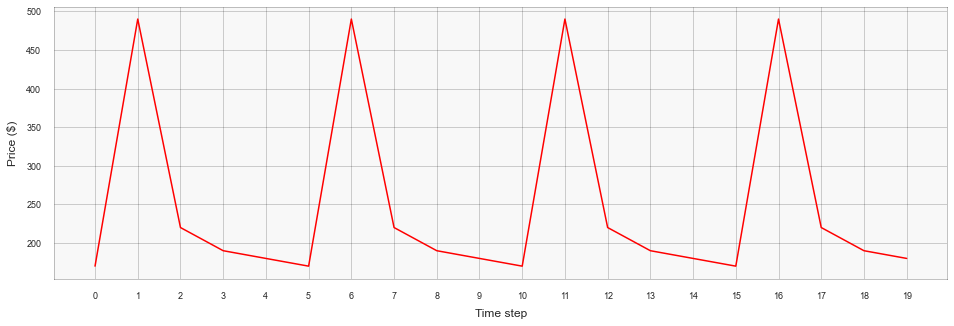

In [49]:
# Find optimal sequence of prices using greedy search

def find_optimal_price_t(p_baseline, price_grid, t):
    p_grid = np.tile(p_baseline, (len(price_grid), 1))
    p_grid[:, t] = price_grid
    profit_grid = np.array([ profit_response(p) for p in p_grid ])
    return price_grid[ np.argmax(profit_grid) ]

p_opt = np.repeat(price_opt_const, T)
for t in range(T):
    price_t = find_optimal_price_t(p_opt, price_grid, t)
    p_opt[t] = price_t

print(p_opt)
print(f'Achieved profit is {profit_response(p_opt)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt, c='red')

# Visualization Functions

This section defines several auxillary visualization function used to visualize the results of the optimization, as well as some debuggin information.

In [68]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

Loading BokehJS ...

# Solution: Pricing Policy Optimization Using DQN
In this section, we develop a standalone DQN-based optimizer using PyTorch.

Episode 980 of 1000 (98.00%)
Best profit results: 2701493.4147382528
Best profit results: 2706682.776433358
Best profit results: 2706922.3985564043
Best profit results: 2708377.3453947785
Best profit results: 2711933.975866207
Best profit results: 2723089.1720143883
Best profit results: 2731497.5825863467
Best profit results: 2736906.4263814017
Best profit results: 2748329.9139185636
Best profit results: 2768795.175285104


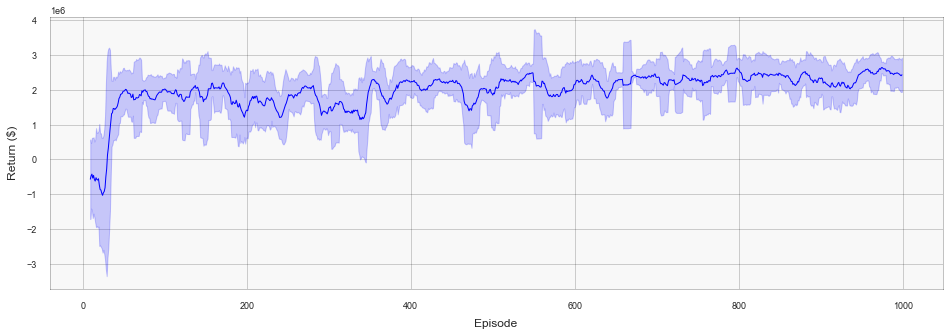

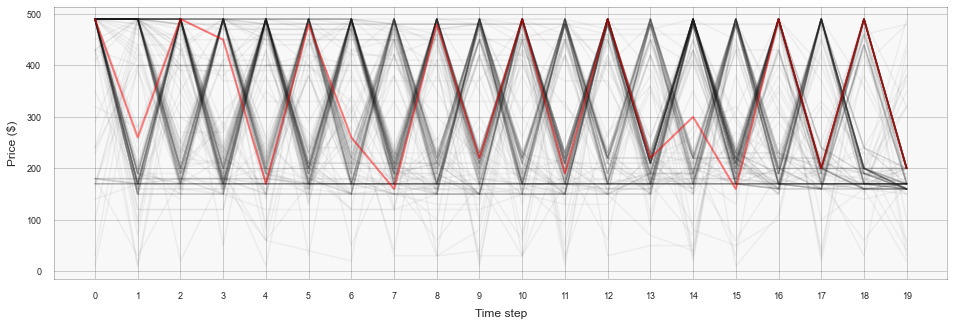

In [70]:
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values  

class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))

GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_intial_state():
    return np.repeat(0, 2*T)

def env_step(t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    reward = profit_t_response(next_state[0], next_state[1])
    return next_state, reward

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 1000
return_trace = []
p_trace = [] # price schedules used in each episode
for i_episode in range(num_episodes):
    state = env_intial_state()
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

plot_return_trace(return_trace)

fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 1, fig.number)

for profit in sorted(profit_response(s) for s in p_trace)[-10:]:
    print(f'Best profit results: {profit}')

# Solution: Visualizing and Debugging DQN Policy Training

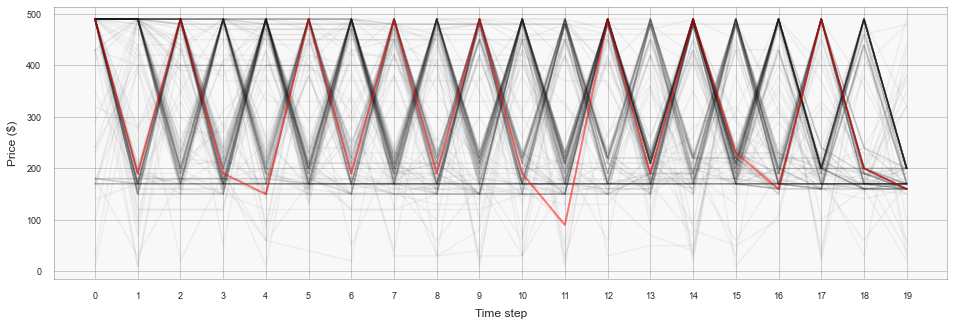

In [101]:
# Render and save the animation of the simulation process
# !apt install imagemagick

plt.ioff()
fig = plt.figure(figsize=(16, 5))
def animate(t):
    fig.clear()
    plot_price_schedules(p_trace[0:t], 5, 1, fig.number)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(10, 1000, 10), interval=50, blit=False, repeat_delay=500)
ani.save('sim.gif', dpi=80, writer='imagemagick', fps=20)
rc('animation', html='jshtml')

Optimal price action 490


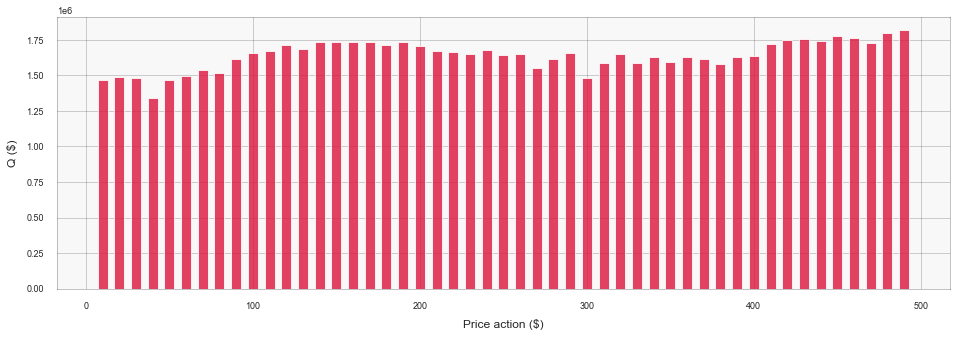

In [72]:
# Visualize Q values for a given state
sample_state = [170.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., \
                1.,     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]
Q_s = policy_net(to_tensor(sample_state))
a_opt = Q_s.max(0)[1].detach()
print(f'Optimal price action {price_grid[a_opt]}')

plt.figure(figsize=(16, 5))
plt.xlabel("Price action ($)")
plt.ylabel("Q ($)")
plt.bar(price_grid, Q_s.detach().numpy(), color='crimson',  width=6, alpha=0.8)
plt.show()

In [73]:
# Debugging Q-values computations

transitions = memory.sample(10)
batch = Transition(*zip(*transitions))

non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

state_batch = torch.stack(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.stack(batch.reward)

state_action_values = policy_net(state_batch).gather(1, action_batch)

next_state_values = torch.zeros(len(transitions), device=device)
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

expected_state_action_values = (next_state_values * GAMMA) + reward_batch[:, 0]

q_trace = []
for t in range(len(transitions)):
    print(f"Q_(s,a)[ {expected_state_action_values[t]} ] = r [ {reward_batch[t].item()} ] + g*Q_(s+1)[ {next_state_values[t]} ]  <> Q_(s,a)[ {state_action_values[t].item()} ]")
    q_trace.append([f"Sample {t}", state_action_values[t].item(), [reward_batch[t].item(), next_state_values[t]]])

Q_(s,a)[ 2141460.75 ] = r [ 100000.0 ] + g*Q_(s+1)[ 2041460.75 ]  <> Q_(s,a)[ 2094183.875 ]
Q_(s,a)[ 1384296.625 ] = r [ 0.0 ] + g*Q_(s+1)[ 1384296.625 ]  <> Q_(s,a)[ 1365058.125 ]
Q_(s,a)[ 274438.90625 ] = r [ 0.0 ] + g*Q_(s+1)[ 274438.90625 ]  <> Q_(s,a)[ 279584.46875 ]
Q_(s,a)[ 1544810.125 ] = r [ 272065.21875 ] + g*Q_(s+1)[ 1272744.875 ]  <> Q_(s,a)[ 1489346.75 ]
Q_(s,a)[ 2366962.0 ] = r [ 269180.125 ] + g*Q_(s+1)[ 2097781.75 ]  <> Q_(s,a)[ 2348815.0 ]
Q_(s,a)[ 691646.75 ] = r [ 270293.875 ] + g*Q_(s+1)[ 421352.875 ]  <> Q_(s,a)[ 689799.3125 ]
Q_(s,a)[ 1503163.25 ] = r [ 261618.703125 ] + g*Q_(s+1)[ 1241544.5 ]  <> Q_(s,a)[ 1465243.375 ]
Q_(s,a)[ 1320095.0 ] = r [ 261925.265625 ] + g*Q_(s+1)[ 1058169.75 ]  <> Q_(s,a)[ 1257714.25 ]
Q_(s,a)[ 2467159.0 ] = r [ 0.0 ] + g*Q_(s+1)[ 2467159.0 ]  <> Q_(s,a)[ 2463850.5 ]
Q_(s,a)[ 543818.1875 ] = r [ 0.0 ] + g*Q_(s+1)[ 543818.1875 ]  <> Q_(s,a)[ 557656.5 ]


<ipython-input-102-d3252181b335>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bullet_graph(np.array(q_trace),
<ipython-input-68-ed6b9159f71e>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([item[0]])


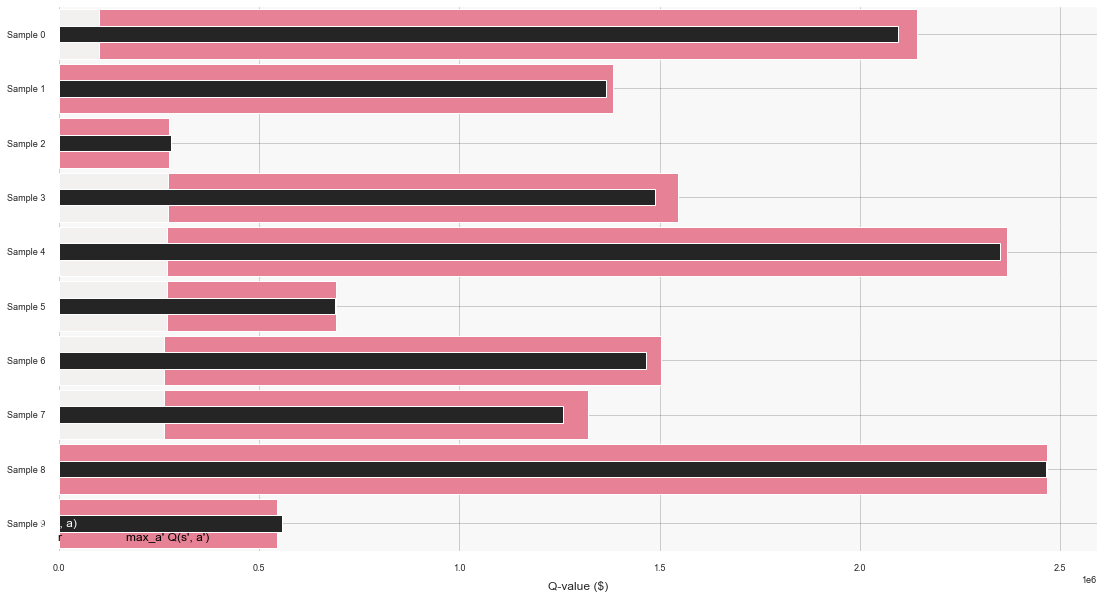

In [102]:
# Visualization of the debugging infomation for Q-values 

palette = sns.light_palette("crimson", 3, reverse=False)
bullet_graph(np.array(q_trace),
            labels=["r", "max_a' Q(s', a')"], bar_label="Q(s, a)", size=(20, 10),
            axis_label="Q-value ($)", label_color="black",
            bar_color="#252525", palette=palette)

In [75]:
# Playing several episods and recording Q-values with the corresponding actual retunrs

num_episodes = 100
return_trace = []
q_values_rewards_trace = np.zeros((num_episodes, T, 2, ))
for i_episode in range(num_episodes):
    state = env_intial_state()
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state)).detach().numpy()
        action = policy.select_action(q_values)

        next_state, reward = env_step(t, state, action)

        # Move to the next state
        state = next_state

        q_values_rewards_trace[i_episode][t][0] = q_values[action]
        for tau in range(t):
            q_values_rewards_trace[i_episode][tau][1] += reward * (GAMMA ** (t - tau)) 

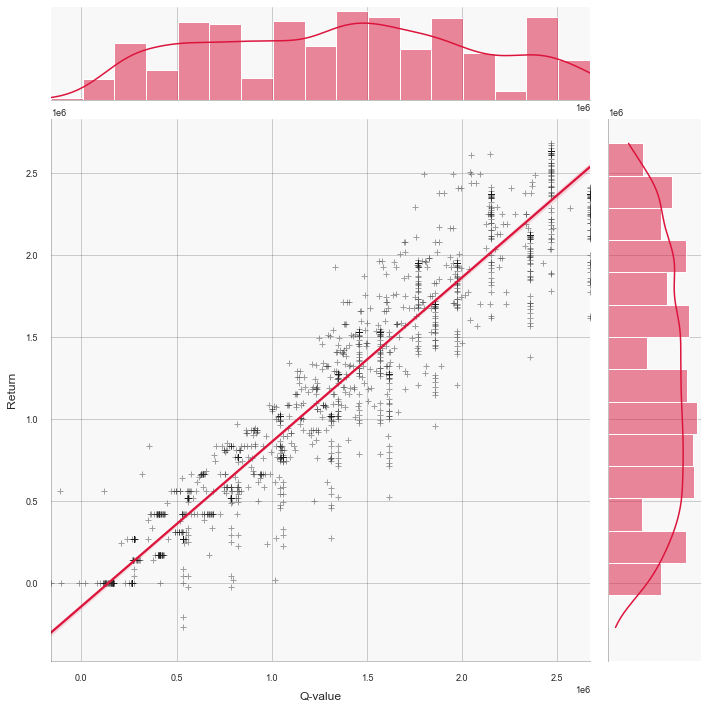

In [94]:
# Visualizing the distribution of Q-value vs actual returns 

values = np.reshape(q_values_rewards_trace, (num_episodes * T, 2, ))

df = pd.DataFrame(data=values, columns=['Q-value', 'Return'])
g = sns.jointplot(x="Q-value", y="Return", data=df, kind="reg", color="crimson", height=10)
g.plot_joint(plt.scatter, c="k", s=30, linewidth=1, marker="+", alpha=0.4)
g.ax_joint.collections[0].set_alpha(0)  

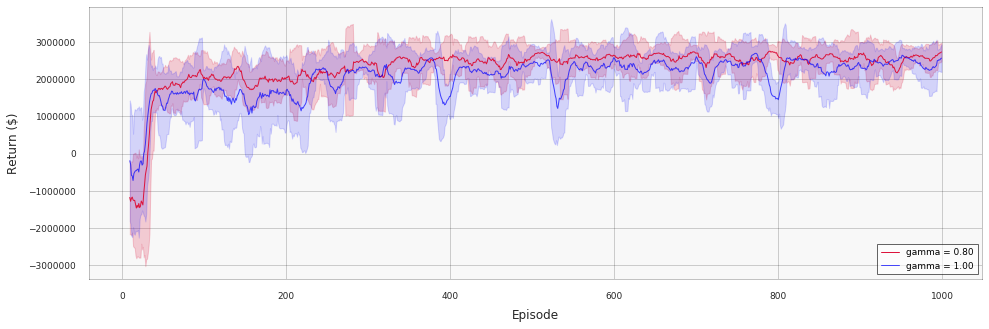

In [ ]:
# Comparing the learning effeciency for different hyperpatarer values
# return_trace_gamma_080 and return_trace_gamma_100 are traces 
# recorded in the Solution section above for gamma=0.80 and gamma=1.00

plt.figure(figsize=(16, 5))
plt.xlabel("Episode")
plt.ylabel("Return ($)")
returns_df = pd.Series(return_trace_gamma_080)
ma = returns_df.rolling(window=10).mean()
mstd = returns_df.rolling(window=10).std()
plt.plot(ma, c = 'crimson', alpha = 1.00, linewidth = 1)
plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='crimson', alpha=0.2)

returns_df = pd.Series(return_trace_gamma_100)
ma = returns_df.rolling(window=10).mean()
mstd = returns_df.rolling(window=10).std()
plt.plot(ma, c = 'blue', alpha = 0.70, linewidth = 1)
plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='blue', alpha=0.15)

plt.legend(["gamma = 0.80", "gamma = 1.00"], loc='lower right', fancybox=False, framealpha=0.6)

# Solution: Implementing DQN Optimizer using RLLib

In this section, we reimplement the DQN-based optimizer using RLlib. 

In [ ]:
!pip uninstall -y -q pyarrow
!pip install -q ray[debug]

try:
    %tensorflow_version 2.x
except Exception:
    pass

# A hack to force the runtime to restart, needed to include the above dependencies.
import os
os._exit(0)

In [ ]:
import gym
from gym.spaces import Discrete, Box

import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print

class HiLoPricingEnv(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Discrete(len(price_grid))
        self.observation_space = Box(0, 10000, shape=(2*T, ), dtype=np.float32)

    def reset(self):
        self.state = env_intial_state()
        self.t = 0
        return self.state

    def step(self, action):
        next_state, reward = env_step(self.t, state, action)
        self.t += 1
        self.state = next_state
        return next_state, reward, self.t == T - 1, {}

ray.shutdown()
ray.init()

def train_dqn():
    config = dqn.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["lr"] = 0.002
    config["gamma"] = 0.80
    config["train_batch_size"] = 256
    config["buffer_size"] = 10000
    config["timesteps_per_iteration"] = 5000
    config["hiddens"] = [128, 128, 128]
    config["exploration_final_eps"] = 0.01
    trainer = dqn.DQNTrainer(config=config, env=HiLoPricingEnv)
    for i in range(50):
        result = trainer.train()
        print(pretty_print(result))

train_dqn()